# Week 4_Day 5: Model Diagnostics + Bias–Variance

In this notebook, I will learn to debug models. First to work today I will choose the Heart-Disease Dataset.

## Full Heart Disease Model Import from Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, classification_report,make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("heart_cleveland_upload.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [3]:
# Selecting all columns as features except Condition
X = df.drop(columns=["condition"])

# Selecting Condition as Target
y = df["condition"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
# building the pipeline
baseline_logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

# training the dataset with baseline logistic regression
baseline_logreg.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000))])

In [6]:
models = {}

# 1. LogisticRegression
models["Logistic Regression"] = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

# 2. KNN Baseline
models["KNN (Untuned)"] = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))    
])

# 3. SVM(RBF)
models["SVM (Untuned)"] = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

# 4. Decision Tree
models["Decision Tree"] = DecisionTreeClassifier(random_state=911)

# 5. Random Forest
models["Random Forest"] = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    n_jobs=-1
)

In [7]:
# tuning Logistic Regression
log_reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])

param_grid_logreg = {
    "logreg__penalty": ["l1", "l2"],
    "logreg__C": [0.01, 0.1, 1, 10, 100],
    "logreg__solver": ["liblinear"],        # supports both l1 and l2
    "logreg__class_weight": [None, "balanced"],
    "logreg__max_iter": [100, 200, 500, 1000],
}

grid_log_reg = GridSearchCV(
    estimator=log_reg_pipe,
    param_grid=param_grid_logreg,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_log_reg.fit(X_train, y_train)
print("Best Logistic Regression Params in training: ", grid_log_reg.best_params_)

best_log_reg = grid_log_reg.best_estimator_
models["Logistic Regression (Tuned)"] = best_log_reg

Best Logistic Regression Params in training:  {'logreg__C': 0.1, 'logreg__class_weight': 'balanced', 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [8]:
# tuning KNN 
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())    
])

param_grid_knn = {
    "knn__n_neighbors": [3,5,7,11,15],
    "knn__weights": ["uniform", "distance"]
}

grid_knn = GridSearchCV(
    estimator = knn_pipe,
    param_grid = param_grid_knn,
    cv = 5, 
    scoring = "accuracy",
    n_jobs = -1
)

grid_knn.fit(X_train, y_train)
print("Best KNN Params in training: ", grid_knn.best_params_)

best_knn = grid_knn.best_estimator_
models["KNN (Tuned)"] = best_knn

Best KNN Params in training:  {'knn__n_neighbors': 15, 'knn__weights': 'uniform'}


In [9]:
# tuning SVM 
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())
])

param_grid_svm = {
    "svc__kernel": ["rbf"],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": [0.01, 0.1, 1.0]
}

grid_svm = GridSearchCV(
    estimator = svm_pipe,
    param_grid = param_grid_svm,
    cv = 5, 
    scoring = "accuracy",
    n_jobs = -1
)

grid_svm.fit(X_train, y_train)
print("Best SVM Params in training: ", grid_svm.best_params_)

best_svm = grid_svm.best_estimator_
models["SVM (Tuned)"] = best_svm

Best SVM Params in training:  {'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


In [10]:
# helper function to evaluate with all models
def model_evaluation(name, model, X_train, y_train, X_test, y_test):
    # train model
    model.fit(X_train, y_train)
    # predictions
    y_pred = model.predict(X_test)

    # metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"{name:30s} -> acc: {acc:.4f} | prec: {prec:.4f} | recall: {rec:.4f} | f1: {f1:.4f}")

    return acc, prec, rec, f1

In [11]:
# evaluating all models
results = []

for name, model in models.items():
    acc, prec, rec, f1 = model_evaluation(name, model, X_train, y_train, X_test, y_test)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

Logistic Regression            -> acc: 0.9167 | prec: 1.0000 | recall: 0.8214 | f1: 0.9020
KNN (Untuned)                  -> acc: 0.9000 | prec: 1.0000 | recall: 0.7857 | f1: 0.8800
SVM (Untuned)                  -> acc: 0.9000 | prec: 1.0000 | recall: 0.7857 | f1: 0.8800
Decision Tree                  -> acc: 0.8167 | prec: 0.8400 | recall: 0.7500 | f1: 0.7925
Random Forest                  -> acc: 0.8833 | prec: 0.9565 | recall: 0.7857 | f1: 0.8627
Logistic Regression (Tuned)    -> acc: 0.9000 | prec: 1.0000 | recall: 0.7857 | f1: 0.8800
KNN (Tuned)                    -> acc: 0.8667 | prec: 1.0000 | recall: 0.7143 | f1: 0.8333
SVM (Tuned)                    -> acc: 0.8667 | prec: 1.0000 | recall: 0.7143 | f1: 0.8333


In [12]:
# dataframe with all evaluation metrics
results_df = (
    pd.DataFrame(results)
    .sort_values(by="Accuracy", ascending=False)
    .reset_index(drop=True)
)

results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.916667,1.000000,0.821429,0.901961
1,KNN (Untuned),0.900000,1.000000,0.785714,0.880000
2,SVM (Untuned),0.900000,1.000000,0.785714,0.880000
3,Logistic Regression (Tuned),0.900000,1.000000,0.785714,0.880000
4,Random Forest,0.883333,0.956522,0.785714,0.862745
5,KNN (Tuned),0.866667,1.000000,0.714286,0.833333
6,SVM (Tuned),0.866667,1.000000,0.714286,0.833333
7,Decision Tree,0.816667,0.840000,0.750000,0.792453


## Model Diagonstics

### Bias vs Variance

In [13]:
model = models["Logistic Regression"]

scoring = {
    "acc": "accuracy",
    "roc_auc": "roc_auc"
}

cv_results = cross_validate(
    model, X_train, y_train,
    cv=5,
    scoring=scoring,
    return_train_score=True
)

print("Train Accuracy:", cv_results["train_acc"].mean())
print("Val Accuracy:  ", cv_results["test_acc"].mean())
print("Train ROC-AUC: ", cv_results["train_roc_auc"].mean())
print("Val ROC-AUC:   ", cv_results["test_roc_auc"].mean())


Train Accuracy: 0.8491896407685882
Val Accuracy:   0.8106382978723404
Train ROC-AUC:  0.9179079039474084
Val ROC-AUC:    0.8872947052947054


**Bias–Variance Diagnosis**

Slight variance, well-regularized, production-acceptable behavior.

There is a small gap between training and validation performance, which is expected.
However, the gap is not large enough to indicate significant overfitting.
The model generalizes reasonably well.

### Regularization

In sklearn LogisticRegression:

**Smaller C** = stronger regularization

**Bigger C** = weaker regularization

In [14]:
C_values = [0.01, 0.1, 1, 10, 100]
scores = []

for C in C_values:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(C=C, max_iter=500))
    ])
    auc = cross_val_score(pipe, X_train, y_train, cv=5, scoring="roc_auc").mean()
    scores.append(auc)
    print(f"C={C:<6} | CV ROC-AUC={auc:.4f}")

C=0.01   | CV ROC-AUC=0.8957
C=0.1    | CV ROC-AUC=0.8904
C=1      | CV ROC-AUC=0.8873
C=10     | CV ROC-AUC=0.8833
C=100    | CV ROC-AUC=0.8826


In [15]:
C_values = [0.01, 1, 100]
coef_norms = []

for C in C_values:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(C=C, max_iter=500))
    ])
    pipe.fit(X_train, y_train)
    coef = pipe.named_steps["lr"].coef_
    norm = np.linalg.norm(coef)
    coef_norms.append(norm)
    print(f"C={C:<6} | Coef norm={norm:.4f}")

C=0.01   | Coef norm=0.5662
C=1      | Coef norm=1.6425
C=100    | Coef norm=1.7454


**Regularization Interpretation**

The cross-validated ROC-AUC scores show that moderate regularization (C = 0.01 or 0.1) achieves the best performance, while weaker regularization (larger C values) slightly reduces validation performance.
This indicates that controlling model complexity helps improve generalization.

The coefficient norms increase as C increases, confirming that weaker regularization allows larger coefficient values.
Stronger regularization shrinks coefficients, reducing model complexity and overfitting risk.

Overall, moderate regularization provides the best bias–variance trade-off for this model.


### Learning Curves

**Simple Rules to read the learning curve**

Case 1: Underfitting
- Train and Val are both low and close

    Fix: more complex model/features

Case 2: Overfitting
- Train high, Val lower, big gap

    Fix: regularization, simpler model, more data

Case 3: Good fit
- Both high and close

    Fix: maybe small tuning, otherwise good

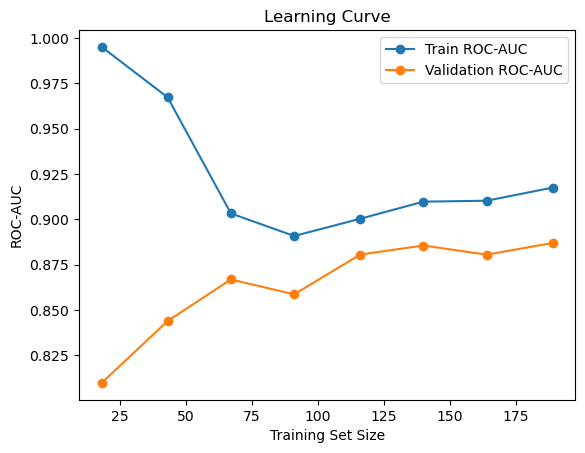

In [16]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(C=1.0, max_iter=500))
])

train_sizes, train_scores, val_scores = learning_curve(
    model,
    X_train, y_train,
    cv=5,
    scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 8),
    random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, marker='o', label="Train ROC-AUC")
plt.plot(train_sizes, val_mean, marker='o', label="Validation ROC-AUC")
plt.xlabel("Training Set Size")
plt.ylabel("ROC-AUC")
plt.title("Learning Curve")
plt.legend()
plt.show()

**Learning Curve Interpretation**

The learning curve shows that as the training set size increases, training performance decreases slightly while validation performance improves.
The gap between training and validation ROC-AUC reduces and stabilizes, indicating a good bias–variance balance.

This suggests that the model generalizes well and does not suffer from significant overfitting or underfitting.
Additional data may yield marginal improvements, but the current model performance is already stable.